In [26]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from tqdm import tqdm
tqdm.pandas()

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)   # default
plt.rc('axes', titlesize=SMALL_SIZE, titleweight='bold')   # axes titles
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')   # x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)   # xtick labels
plt.rc('ytick', labelsize=SMALL_SIZE)   # ytick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend
plt.rc('figure', titlesize=BIGGER_SIZE, titleweight='bold')   # title

combined = pd.read_csv('scored_datasets/combined.csv')
conferences = pd.read_csv('scored_datasets/conferences.csv')
manifestos = pd.read_csv('scored_datasets/manifestos.csv')
pmqs = pd.read_csv('scored_datasets/pmqs.csv')

# 2. Decomposition

## Specificity vs. vagueness

In [2]:
vague_cols = [col for col in combined.columns if 'vague' in col]
vague_arr = combined[vague_cols].to_numpy()

nmf = NMF(n_components=1) # Since all indicators are non-negative, I use Non-negative Matrix Factorisation
nmf.fit(vague_arr)

for name,loading in zip(vague_cols, nmf.components_[0]):
    print("{}: {:.4f}".format(name,loading))
    
vague_score = nmf.transform(vague_arr)
vague_df = combined[['type','year','party']].copy()
vague_df['vague_score'] = vague_score

vague_inverse_deictic_word_freq: 5.0336
vague_approximator_word_freq: 0.0257
vague_inverse_shield_word_freq: 5.6244
vague_booster_word_freq: 0.1193
vague_avg_semantic_size: 2.6299


C:\Users\natha\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


### Boxplots

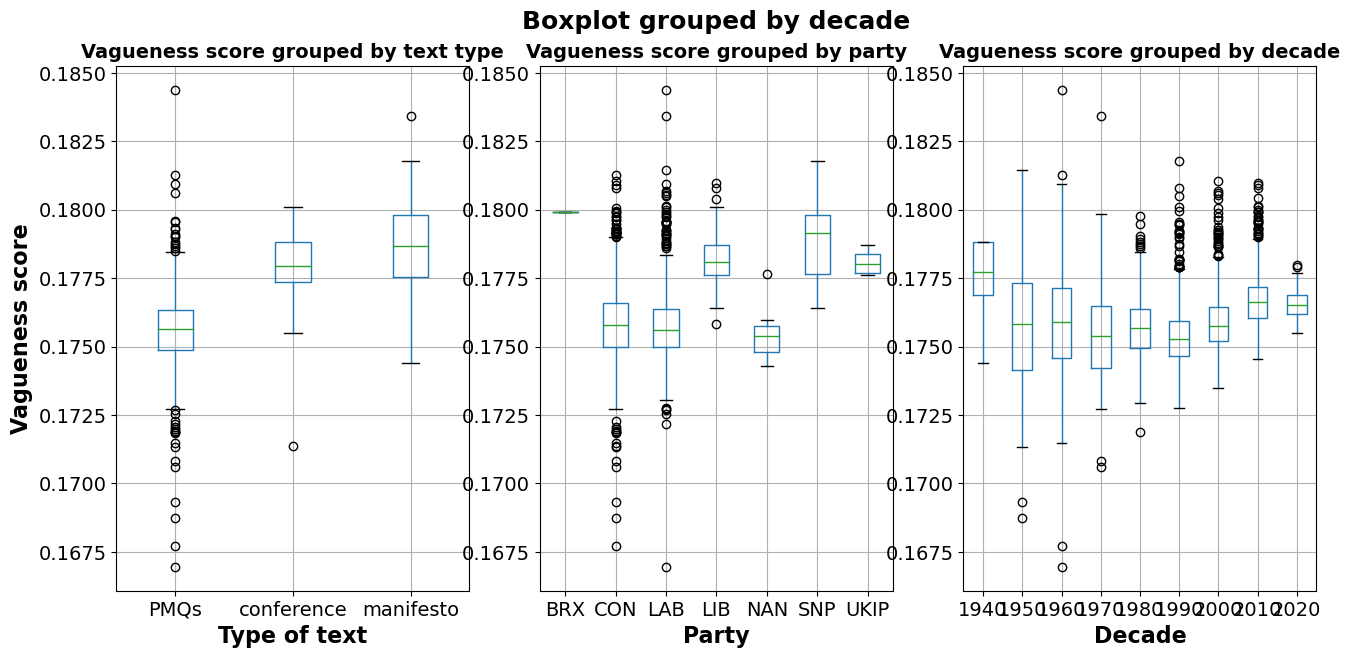

In [3]:
vague_df['decade'] = vague_df.year.apply(lambda date: (pd.to_datetime(date).year//10)*10)

fig,axs = plt.subplots(1,3, figsize=(15,7))

vague_df.boxplot(column='vague_score',by='type',ax=axs[0])
axs[0].set_ylabel("Vagueness score")
axs[0].set_xlabel("Type of text")
axs[0].set_title("Vagueness score grouped by text type")

vague_df.boxplot(column='vague_score',by='party',ax=axs[1])
axs[1].set_xlabel("Party")
axs[1].set_title("Vagueness score grouped by party")

vague_df.boxplot(column='vague_score',by='decade',ax=axs[2])
axs[2].set_xlabel("Decade")
axs[2].set_title("Vagueness score grouped by decade")

plt.savefig('../figs/boxplots/vagueness.png')
plt.show()

Makes intuitive sense - in PMQs, politicians debate that week's news stories, and at annual party conferences, the issues of that year are discussed. In manifestos, leaders have an opportunity to set out broader, more general arguments about the directions they want to take the country over the next few years.

Notable difference in vagueness between mainstream and 'third' parties, e.g. LD, SNP, UKIP. 

There's a slight upward trend from the 1980s/1990s onwards, which is roughly what theory would suggest.

In [32]:
vague_mod = smf.ols('vague_score ~ type', data=vague_df).fit()
print(sm.stats.anova_lm(vague_mod).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      df &    sum\_sq &   mean\_sq &           F &         PR(>F) \\
\midrule
type     &     2.0 &  0.001517 &  0.000759 &  526.582536 &  1.789088e-185 \\
Residual &  2062.0 &  0.002970 &  0.000001 &         NaN &            NaN \\
\bottomrule
\end{tabular}



### Plotting the time trend

100%|█████████████████████████████████████████████████████████████████████████████| 2065/2065 [00:06<00:00, 320.46it/s]


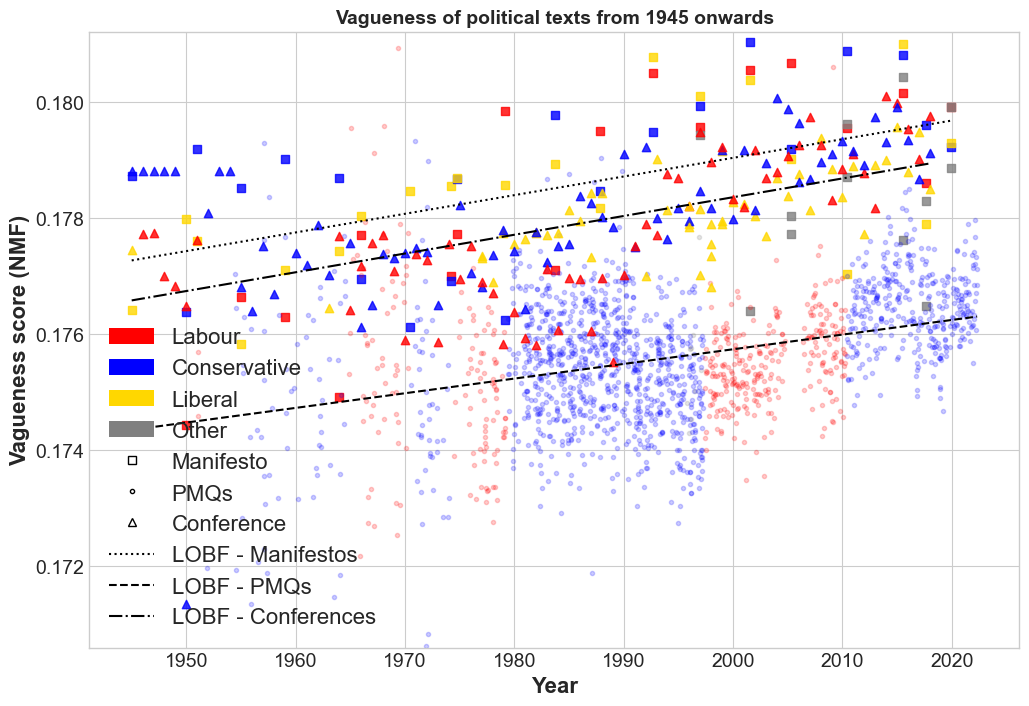

In [4]:
col_dict = {'LAB':'red','CON':'blue','LIB':'gold','SNP':'grey','UKIP':'grey','BRX':'grey','NAN':'grey'}
legend_col_dict = {'LAB':'red','CON':'blue','LIB':'gold','OTHER':'grey'}
marker_dict = {'manifesto':'s','PMQs':'.','conference':'^'}
alpha_dict = {'manifesto':0.8,'PMQs':0.2,'conference':0.8}

plt.style.use('seaborn-whitegrid')
fig,ax = plt.subplots(1, figsize=(12,8))
        
vague_df.progress_apply(lambda row: ax.scatter(pd.to_datetime(row.year), row.vague_score,
                                               color=col_dict[row.party],
                                               marker=marker_dict[row.type],
                                               alpha=alpha_dict[row.type]),
                        axis=1)

# Plot line of best fit for manifestos
deg = 1
x = np.array([date for date in pd.to_datetime(vague_df[vague_df.type=='manifesto'].year)])
native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
y = np.array(vague_df[vague_df.type=='manifesto'].vague_score)
coefs = np.polyfit(native_x, y, deg=deg)
xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
ax.plot(pd.to_datetime(xseq), yseq, ':', color='black')

# ...PMQs
x = np.array([date for date in pd.to_datetime(vague_df[vague_df.type=='PMQs'].year)])
native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
y = np.array(vague_df[vague_df.type=='PMQs'].vague_score)
coefs = np.polyfit(native_x, y, deg=deg)
xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
ax.plot(pd.to_datetime(xseq), yseq, '--', color='black')

# ...and conference speeches
x = np.array([date for date in pd.to_datetime(vague_df[vague_df.type=='conference'].year)])
native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
y = np.array(vague_df[vague_df.type=='conference'].vague_score)
coefs = np.polyfit(native_x, y, deg=deg)
xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
ax.plot(pd.to_datetime(xseq), yseq, '-.', color='black')

ax.set_ylim(max(vague_df.vague_score.mean()-(3.6*vague_df.vague_score.std()), vague_df.vague_score.min()-(0.2*vague_df.vague_score.std())),
            min(vague_df.vague_score.mean()+(3.6*vague_df.vague_score.std()), vague_df.vague_score.max()+(0.2*vague_df.vague_score.std())))

colour_labels = ["Labour","Conservative","Liberal","Other"]
marker_labels = ["Manifesto","PMQs","Conference"]
line_labels = ["LOBF - Manifestos","LOBF - PMQs","LOBF - Conferences"]

colour_artists = [mpatches.Patch(facecolor=col) for lab,col in legend_col_dict.items()]
marker_artists = [plt.plot([], [], marker, markerfacecolor='w', markeredgecolor='k')[0] for lab,marker in marker_dict.items()]
line_artists = [mlines.Line2D([],[], linestyle=line_type, color='black') for line_type in [':','--','-.']]

ax.legend(colour_artists+marker_artists+line_artists,
          colour_labels+marker_labels+line_labels)

ax.set_xlabel("Year")
ax.set_ylabel("Vagueness score (NMF)")
ax.set_title("Vagueness of political texts from 1945 onwards")

plt.savefig('../figs/nmf/vagueness.png')
plt.show()

## Objectivity vs. subjectivity

In [5]:
subj_cols = [col for col in combined.columns if 'subj' in col]
subj_arr = combined[subj_cols].to_numpy()

nmf = NMF(n_components=1) # Since all indicators are non-negative, I use Non-negative Matrix Factorisation
nmf.fit(subj_arr)

for name,loading in zip(subj_cols, nmf.components_[0]):
    print("{}: {:.4f}".format(name,loading))
    
subj_score = nmf.transform(subj_arr)
subj_df = combined[['type','year','party']].copy()
subj_df['subj_score'] = subj_score

subj_subjective_sentence_freq: 0.4520
subj_avg_subjective_sentence_score: 3.9030
subj_speculative_sentence_freq: 2.3419
subj_modal_verb_freq: 0.2332
subj_subjective_adjective_freq: 0.4203


C:\Users\natha\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\natha\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### Boxplots

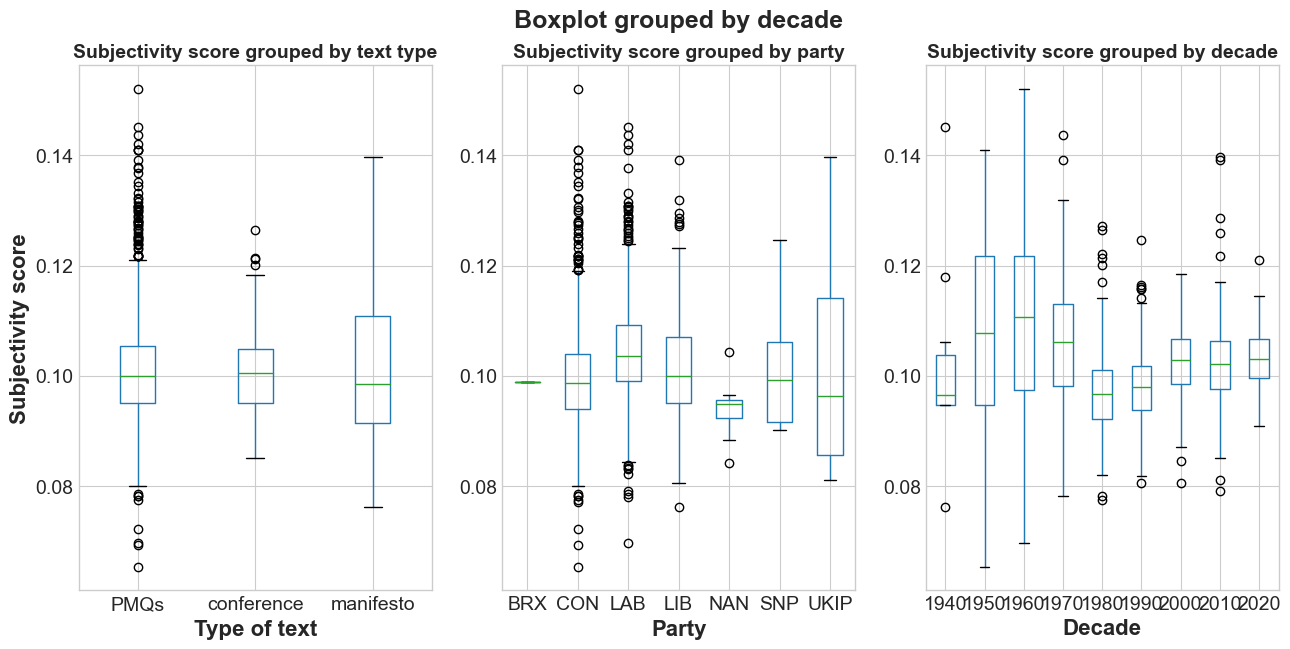

In [6]:
subj_df['decade'] = subj_df.year.apply(lambda date: (pd.to_datetime(date).year//10)*10)

fig,axs = plt.subplots(1,3, figsize=(15,7))

subj_df.boxplot(column='subj_score',by='type',ax=axs[0])
axs[0].set_ylabel("Subjectivity score")
axs[0].set_xlabel("Type of text")
axs[0].set_title("Subjectivity score grouped by text type")

subj_df.boxplot(column='subj_score',by='party',ax=axs[1])
axs[1].set_xlabel("Party")
axs[1].set_title("Subjectivity score grouped by party")

subj_df.boxplot(column='subj_score',by='decade',ax=axs[2])
axs[2].set_xlabel("Decade")
axs[2].set_title("Subjectivity score grouped by decade")

plt.savefig('../figs/boxplots/subjectivity.png')
plt.show()

Not much difference in subjectivity - but far more variance among PMQs responses.

Again, not much difference in terms of subjectivity.

Strangely - and perhaps contrary to theoretical claims - it seems that the use of subjective language has actually declined from the period before the 1970s to the period after the 1970s. 

In [47]:
subj_mod = smf.ols('subj_score ~ type', data=subj_df).fit() 
print(sm.stats.anova_lm(subj_mod).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      df &    sum\_sq &   mean\_sq &         F &    PR(>F) \\
\midrule
type     &     2.0 &  0.000122 &  0.000061 &  0.690936 &  0.501223 \\
Residual &  2062.0 &  0.182241 &  0.000088 &       NaN &       NaN \\
\bottomrule
\end{tabular}



### Plotting the time trend

100%|█████████████████████████████████████████████████████████████████████████████| 2065/2065 [00:07<00:00, 273.66it/s]


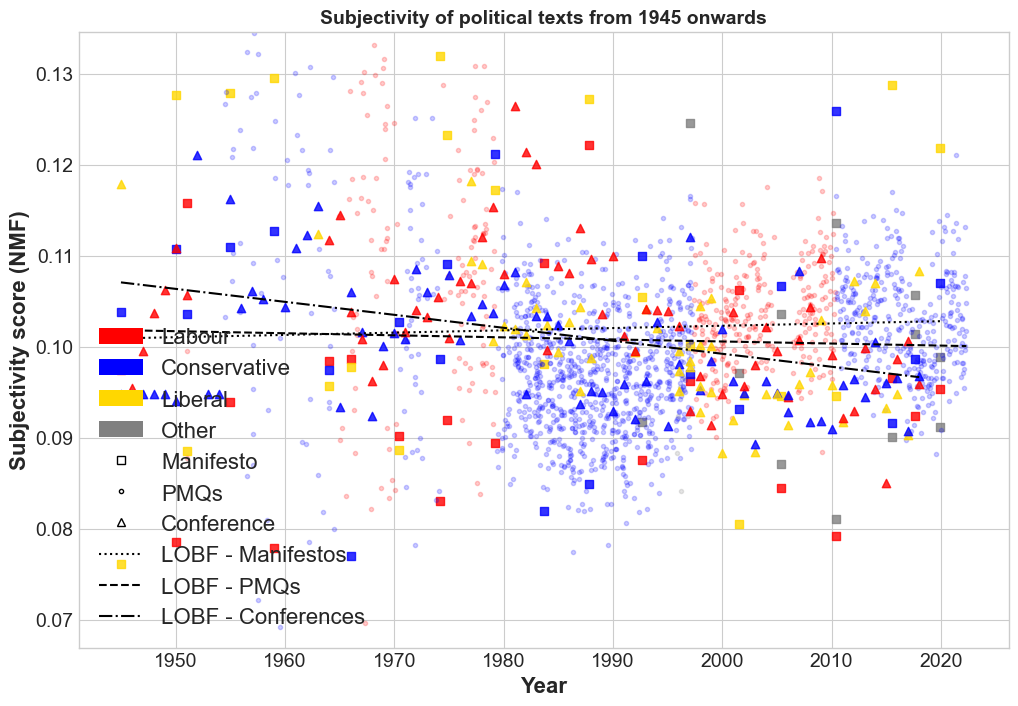

In [7]:
col_dict = {'LAB':'red','CON':'blue','LIB':'gold','SNP':'grey','UKIP':'grey','BRX':'grey','NAN':'grey'}
legend_col_dict = {'LAB':'red','CON':'blue','LIB':'gold','OTHER':'grey'}
marker_dict = {'manifesto':'s','PMQs':'.','conference':'^'}
alpha_dict = {'manifesto':0.8,'PMQs':0.2,'conference':0.8}

plt.style.use('seaborn-whitegrid')
fig,ax = plt.subplots(1, figsize=(12,8))
        
subj_df.progress_apply(lambda row: ax.scatter(pd.to_datetime(row.year), row.subj_score,
                                               color=col_dict[row.party],
                                               marker=marker_dict[row.type],
                                               alpha=alpha_dict[row.type]),
                        axis=1)

# Plot line of best fit for manifestos
deg = 1
x = np.array([date for date in pd.to_datetime(subj_df[subj_df.type=='manifesto'].year)])
native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
y = np.array(subj_df[subj_df.type=='manifesto'].subj_score)
coefs = np.polyfit(native_x, y, deg=deg)
xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
ax.plot(pd.to_datetime(xseq), yseq, ':', color='black')

# ...PMQs
x = np.array([date for date in pd.to_datetime(subj_df[subj_df.type=='PMQs'].year)])
native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
y = np.array(subj_df[subj_df.type=='PMQs'].subj_score)
coefs = np.polyfit(native_x, y, deg=deg)
xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
ax.plot(pd.to_datetime(xseq), yseq, '--', color='black')

# ...and conference speeches
x = np.array([date for date in pd.to_datetime(subj_df[subj_df.type=='conference'].year)])
native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
y = np.array(subj_df[subj_df.type=='conference'].subj_score)
coefs = np.polyfit(native_x, y, deg=deg)
xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
ax.plot(pd.to_datetime(xseq), yseq, '-.', color='black')

ax.set_ylim(max(subj_df.subj_score.mean()-(3.6*subj_df.subj_score.std()), subj_df.subj_score.min()-(0.2*subj_df.subj_score.std())),
            min(subj_df.subj_score.mean()+(3.6*subj_df.subj_score.std()), subj_df.subj_score.max()+(0.2*subj_df.subj_score.std())))
ax.set_xlabel("Year")
ax.set_ylabel("NMF - subjectivity")
ax.set_title("NMF - subjectivity from 1945 onwards")

colour_labels = ["Labour","Conservative","Liberal","Other"]
marker_labels = ["Manifesto","PMQs","Conference"]
line_labels = ["LOBF - Manifestos","LOBF - PMQs","LOBF - Conferences"]

colour_artists = [mpatches.Patch(facecolor=col) for lab,col in legend_col_dict.items()]
marker_artists = [plt.plot([], [], marker, markerfacecolor='w', markeredgecolor='k')[0] for lab,marker in marker_dict.items()]
line_artists = [mlines.Line2D([],[], linestyle=line_type, color='black') for line_type in [':','--','-.']]

ax.legend(colour_artists+marker_artists+line_artists,
          colour_labels+marker_labels+line_labels)

ax.set_xlabel("Year")
ax.set_ylabel("Subjectivity score (NMF)")
ax.set_title("Subjectivity of political texts from 1945 onwards")

plt.savefig('../figs/nmf/subjectivity.png')
plt.show()

## Rationality vs. emotion

In [8]:
emot_cols = [col for col in combined.columns if 'emot' in col]
emot_arr = combined[emot_cols].to_numpy()

nmf = NMF(n_components=1) # Since all indicators are non-negative, I use Non-negative Matrix Factorisation
nmf.fit(emot_arr)

for name,loading in zip(emot_cols, nmf.components_[0]):
    print("{}: {:.4f}".format(name,loading))
    
emot_score = nmf.transform(emot_arr)
emot_df = combined[['type','year','party']].copy()
emot_df['emot_score'] = emot_score

emot_avg_arousal_glasgow: 2.8232
emot_avg_arousal_warriner: 2.3884
emot_avg_valence_glasgow: 1.5149
emot_avg_valence_warriner: 1.3387
emot_avg_valence_rheault: 2.7946
emot_avg_anger_sentence_score: 2.8382
emot_avg_fear_sentence_score: 2.9047
emot_avg_joy_sentence_score: 2.8830
emot_avg_sadness_sentence_score: 2.6863


C:\Users\natha\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


### Boxplots

#### Emotionality by type

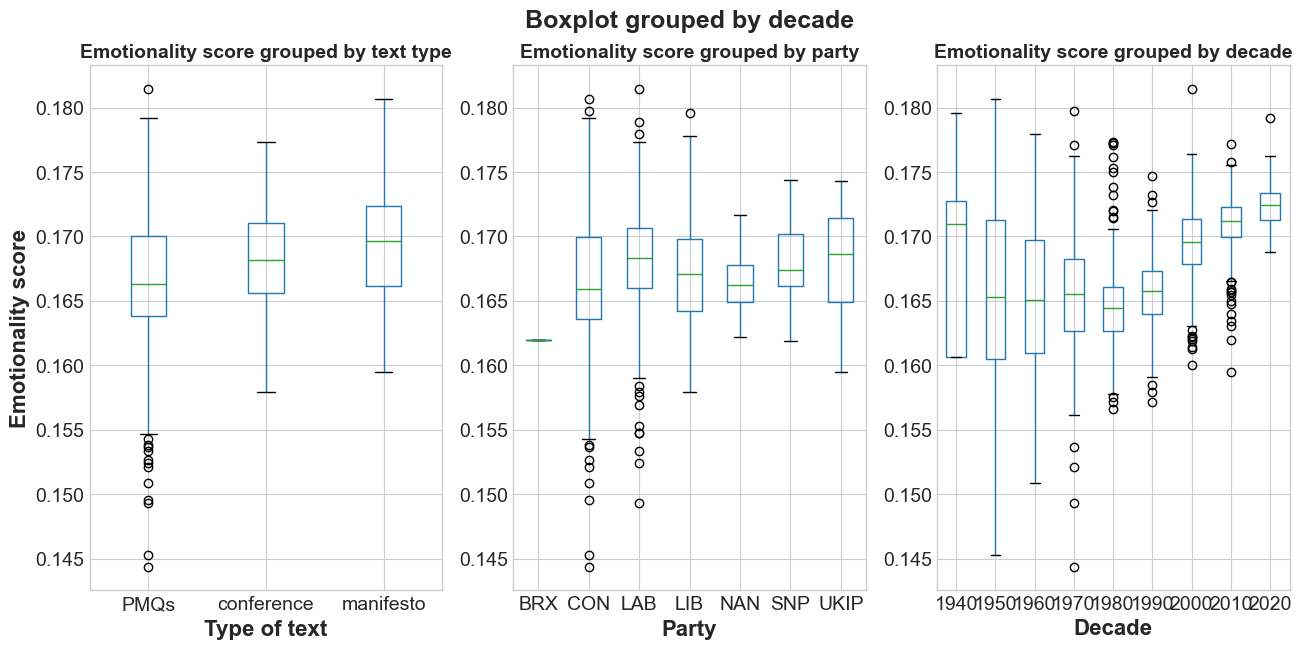

In [9]:
emot_df['decade'] = emot_df.year.apply(lambda date: (pd.to_datetime(date).year//10)*10)

fig,axs = plt.subplots(1,3, figsize=(15,7))

emot_df.boxplot(column='emot_score',by='type',ax=axs[0])
axs[0].set_ylabel("Emotionality score")
axs[0].set_xlabel("Type of text")
axs[0].set_title("Emotionality score grouped by text type")

emot_df.boxplot(column='emot_score',by='party',ax=axs[1])
axs[1].set_xlabel("Party")
axs[1].set_title("Emotionality score grouped by party")

emot_df.boxplot(column='emot_score',by='decade',ax=axs[2])
axs[2].set_xlabel("Decade")
axs[2].set_title("Emotionality score grouped by decade")

plt.savefig('../figs/boxplots/emotionality.png')
plt.show()

PMQs is slightly less emotional - this makes intuitive sense, since PMQs is concerned with topical news stories, whereas speeches and forewords offer opportunities for normative judgements about longer-term issues.

#### Emotionality by party

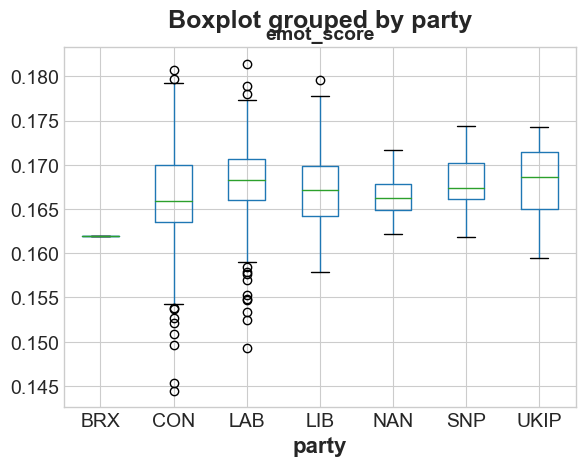

In [10]:
emot_df.boxplot(column='emot_score',by='party')
plt.show()

No clear link between party and emotionality.

#### Emotionality by decade

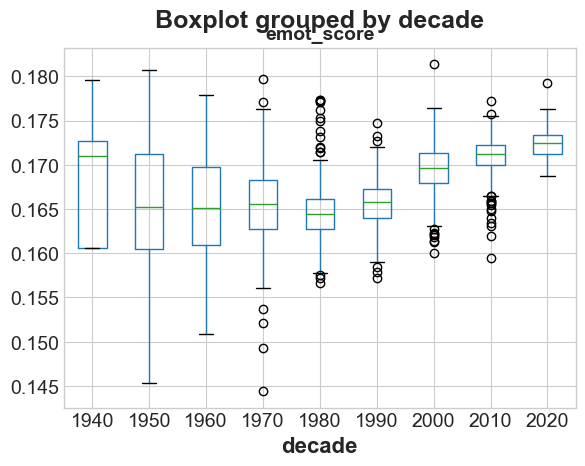

In [11]:
emot_df['decade'] = emot_df.year.apply(lambda date: (pd.to_datetime(date).year//10)*10)
emot_df.boxplot(column='emot_score',by='decade')
plt.show()

Pretty clear increase in emotionality from 1970 onwards.

In [46]:
emot_mod = smf.ols('emot_score ~ type', data=emot_df).fit() 
print(sm.stats.anova_lm(emot_mod).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      df &    sum\_sq &   mean\_sq &          F &        PR(>F) \\
\midrule
type     &     2.0 &  0.000895 &  0.000448 &  25.360642 &  1.316115e-11 \\
Residual &  2062.0 &  0.036396 &  0.000018 &        NaN &           NaN \\
\bottomrule
\end{tabular}



### Plotting the time trend

100%|█████████████████████████████████████████████████████████████████████████████| 2065/2065 [00:06<00:00, 313.10it/s]


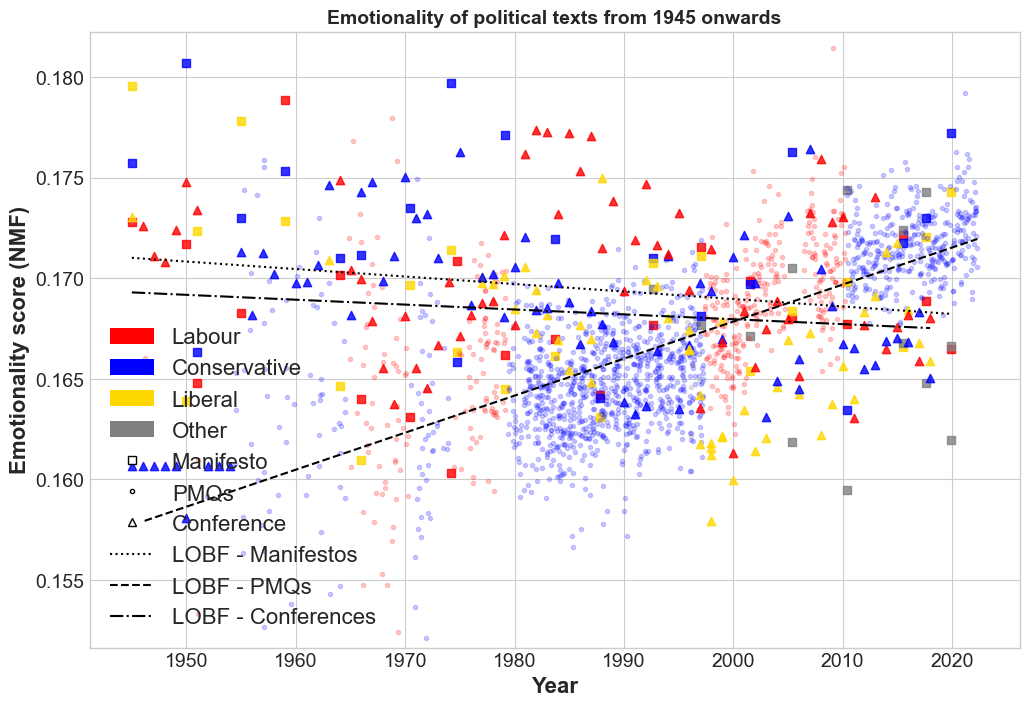

In [12]:
col_dict = {'LAB':'red','CON':'blue','LIB':'gold','SNP':'grey','UKIP':'grey','BRX':'grey','NAN':'grey'}
legend_col_dict = {'LAB':'red','CON':'blue','LIB':'gold','OTHER':'grey'}
marker_dict = {'manifesto':'s','PMQs':'.','conference':'^'}
alpha_dict = {'manifesto':0.8,'PMQs':0.2,'conference':0.8}

plt.style.use('seaborn-whitegrid')
fig,ax = plt.subplots(1, figsize=(12,8))
        
emot_df.progress_apply(lambda row: ax.scatter(pd.to_datetime(row.year), row.emot_score,
                                               color=col_dict[row.party],
                                               marker=marker_dict[row.type],
                                               alpha=alpha_dict[row.type]),
                        axis=1)

# Plot line of best fit for manifestos
deg = 1
x = np.array([date for date in pd.to_datetime(emot_df[emot_df.type=='manifesto'].year)])
native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
y = np.array(emot_df[emot_df.type=='manifesto'].emot_score)
coefs = np.polyfit(native_x, y, deg=deg)
xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
ax.plot(pd.to_datetime(xseq), yseq, ':', color='black')

# ...PMQs
x = np.array([date for date in pd.to_datetime(emot_df[emot_df.type=='PMQs'].year)])
native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
y = np.array(emot_df[emot_df.type=='PMQs'].emot_score)
coefs = np.polyfit(native_x, y, deg=deg)
xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
ax.plot(pd.to_datetime(xseq), yseq, '--', color='black')

# ...and conference speeches
x = np.array([date for date in pd.to_datetime(emot_df[emot_df.type=='conference'].year)])
native_x = [int(xi.timestamp() * 10**9) for xi in x] # convert x to native timestamp
y = np.array(emot_df[emot_df.type=='conference'].emot_score)
coefs = np.polyfit(native_x, y, deg=deg)
xseq = np.linspace(min(native_x)-1, max(native_x)+1, num=500)
XX = np.vstack([xseq**(deg-i) for i in range(deg+1)]).T # rows 1, x, x**2, ...
yseq = np.dot(XX, coefs)  # matrix multiplication by coefs calculates the polynomial values
ax.plot(pd.to_datetime(xseq), yseq, '-.', color='black')

ax.set_ylim(max(emot_df.emot_score.mean()-(3.6*emot_df.emot_score.std()), emot_df.emot_score.min()-(0.2*emot_df.emot_score.std())),
            min(emot_df.emot_score.mean()+(3.6*emot_df.emot_score.std()), emot_df.emot_score.max()+(0.2*emot_df.emot_score.std())))
ax.set_xlabel("Year")
ax.set_ylabel("NMF - emotionality")
ax.set_title("NMF - emotionality from 1945 onwards")

colour_labels = ["Labour","Conservative","Liberal","Other"]
marker_labels = ["Manifesto","PMQs","Conference"]
line_labels = ["LOBF - Manifestos","LOBF - PMQs","LOBF - Conferences"]

colour_artists = [mpatches.Patch(facecolor=col) for lab,col in legend_col_dict.items()]
marker_artists = [plt.plot([], [], marker, markerfacecolor='w', markeredgecolor='k')[0] for lab,marker in marker_dict.items()]
line_artists = [mlines.Line2D([],[], linestyle=line_type, color='black') for line_type in [':','--','-.']]

ax.legend(colour_artists+marker_artists+line_artists,
          colour_labels+marker_labels+line_labels)

ax.set_xlabel("Year")
ax.set_ylabel("Emotionality score (NMF)")
ax.set_title("Emotionality of political texts from 1945 onwards")

plt.savefig('../figs/nmf/emotionality.png')
plt.show()

## Saving decomposed dimensions

In [13]:
decomposed = vague_df.copy()
decomposed['subj_score'] = subj_df.subj_score
decomposed['emot_score'] = emot_df.emot_score
decomposed.to_csv('scored_datasets/decomposed.csv',index=False)